In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from time import gmtime, strftime
import oggm.cfg
from oggm import  utils, workflow, tasks, graphics
import json
import geopandas as gpd

# let's also do some visualisations ...
import matplotlib.pyplot as plt
import seaborn as sns

rgi_reg='11'
basin = 'RHONE' # INDUS
all_GCM = gcms_cmip6.gcm.unique()
all_scenario = gcms_cmip6.ssp.unique()

# get the RGI ids of the glaciers of the chosen basin
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]
f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
rgis_basin = json.load(f)[str(basin_idx)]
len(rgis_basin)
#pd_basin_num.RIVER_BASI.unique()

# choose only relevant variables
variables = ['volume','area','length', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier',
             'melt_off_glacier_monthly', 'melt_on_glacier_monthly', 'liq_prcp_off_glacier_monthly', 'liq_prcp_on_glacier_monthly']

NameError: name 'gcms_cmip6' is not defined

In [ ]:
scenarios = ['stab_T15',
             'oversh_T20OS15',
             'oversh_T25OS15',
             'oversh_T30OS15',
             'stab_T20',
             'stab_T25',
             'stab_T30']

In [ ]:
pal_colorblind = sns.color_palette("colorblind")

In [ ]:
palette = sns.color_palette([pal_colorblind[0], pal_colorblind[-1], pal_colorblind[2],
                             pal_colorblind[1], pal_colorblind[6], pal_colorblind[4],pal_colorblind[3]])
palette

1167
1167


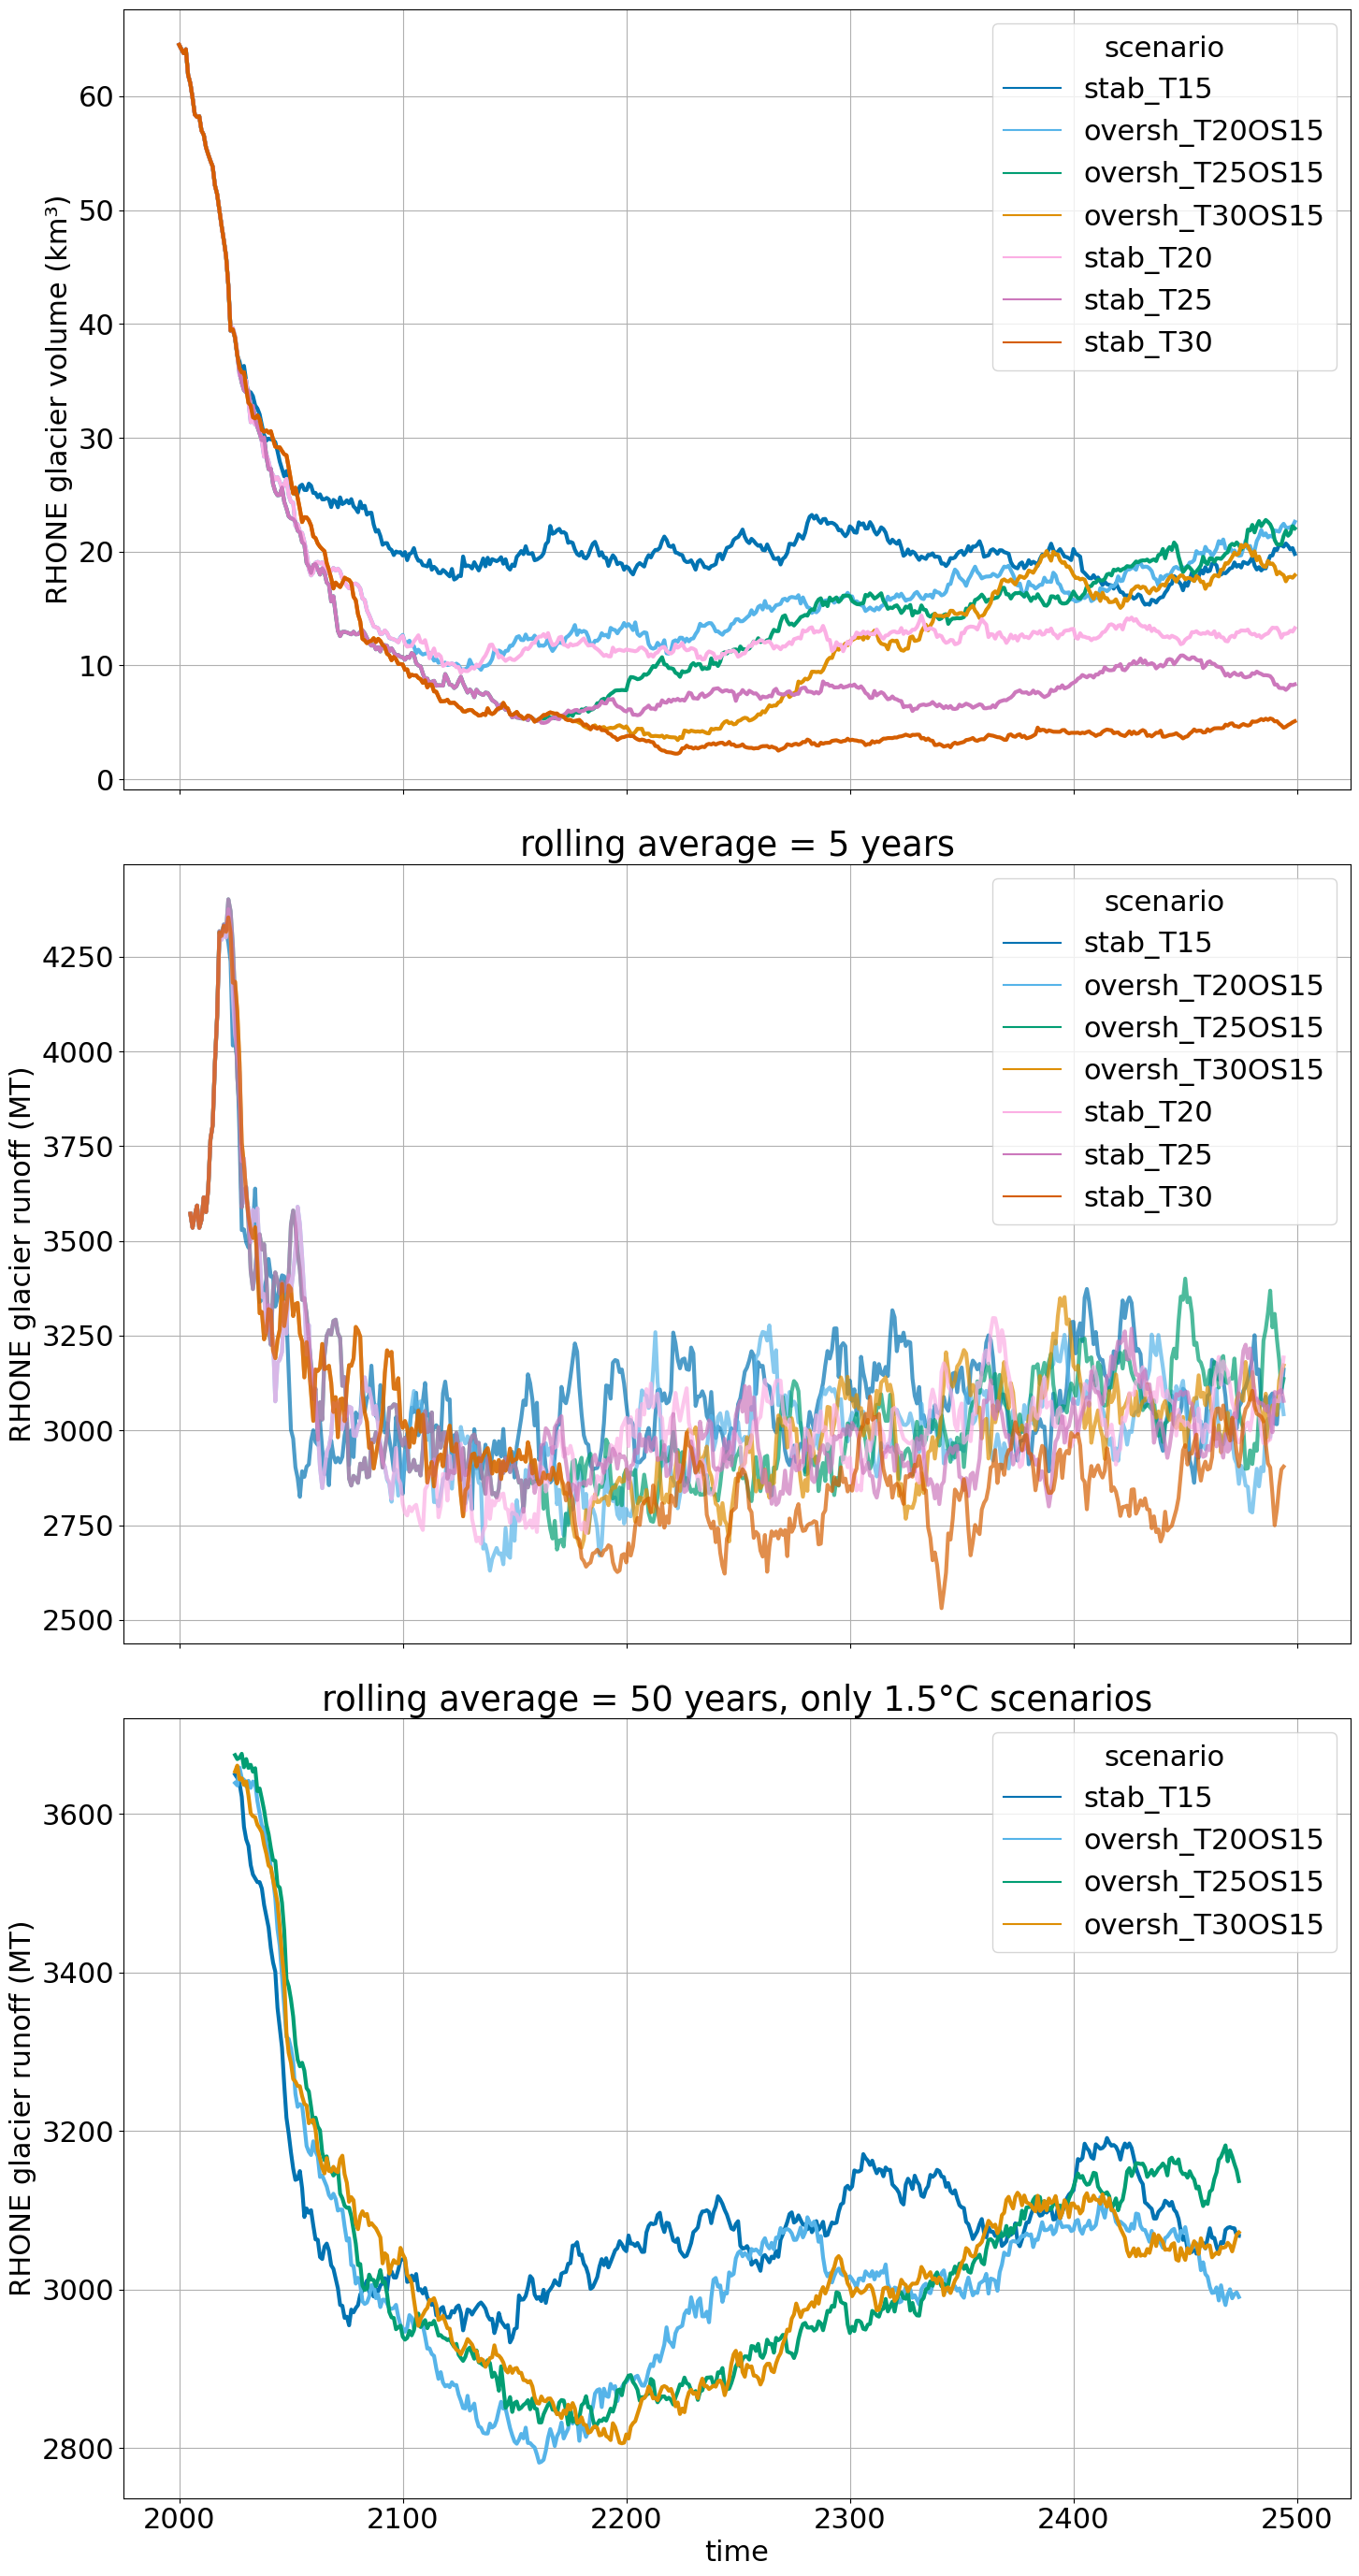

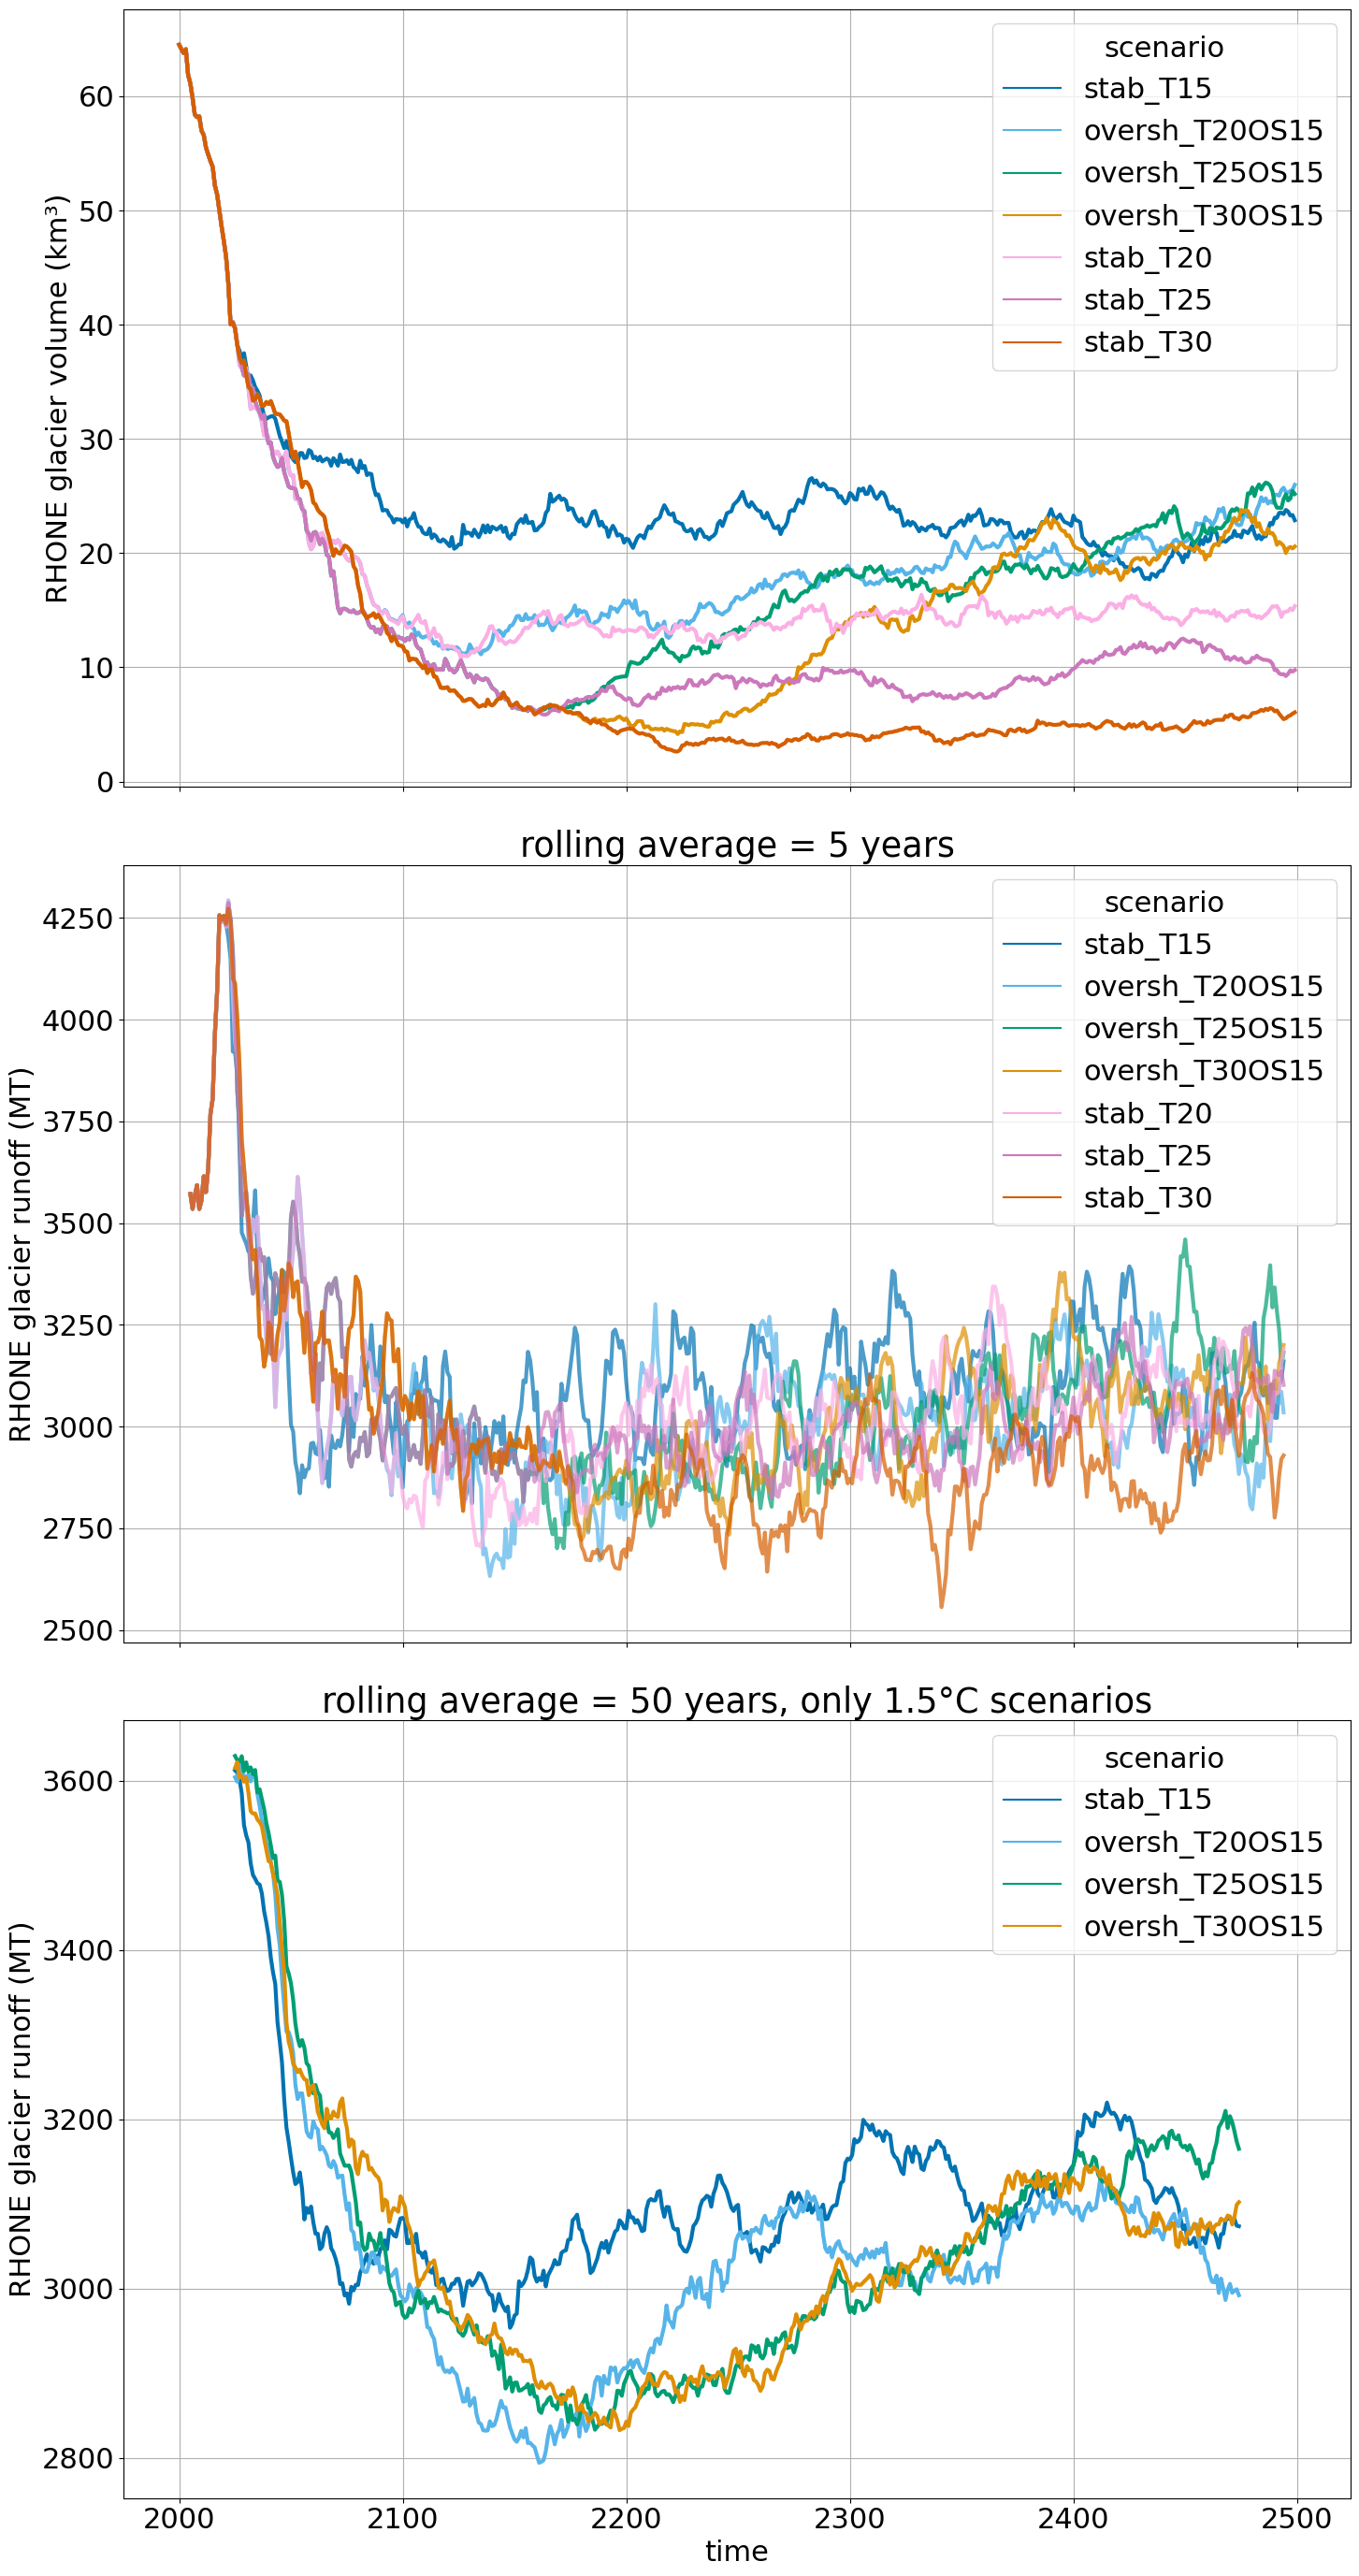

In [131]:
plt.rc('font', size=22)

creation_date = strftime("%Y-%m-%d %H:%M:%S", gmtime())  # here add the current time for info
path = f'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output'
merge = False
if merge:
    ds_all = []  # in this array all datasets going to be stored with additional coordinates GCM and SCENARIO
    for bc in ['2000_2019', '1980_2019']:
        for scen in scenarios:  # loop through all SSPs
            try:  # check if GCM, SCENARIO combination exists
                with xr.open_mfdataset(f'{path}/RGI{rgi_reg}/run_hydro_w5e5_gcm_merged_from_2000_gfdl-esm2m_{scen}_endyr_2500_bc_{bc}_rgi{rgi_reg}_*.nc') as ds_tmp:
                    ds_tmp = ds_tmp[variables]
                    ds_tmp = ds_tmp.sel(rgi_id=rgis_basin).load()
                ds_tmp.coords['gcm'] = 'gfdl-esm2m' #GCM  # add GCM as a coordinate
                ds_tmp.coords['gcm'].attrs['description'] = 'used global circulation model'  # add a description for GCM
                ds_tmp = ds_tmp.expand_dims("gcm")  # add GCM as a dimension to all Data variables

                ds_tmp.coords['scenario'] = scen  # add scenario (here ssp) as a coordinate
                ds_tmp.coords['scenario'].attrs['description'] = 'used scenario (idealised overshoot and stabilisation scenarios)'
                ds_tmp = ds_tmp.expand_dims("scenario")  # add SSO as a dimension to all Data variables

                ds_tmp.attrs['creation_date'] = creation_date  # also add todays date for info
                ds_all.append(ds_tmp)  # add the dataset with extra coordinates to our final ds_all array

            except OSError as err:  # here we land if an error occured
                if str(err) == 'no files to open':  # This is the error message if the GCM, SCENARIO (here ssp) combination does not exist
                    print(f'No data for scenario {scen} found!')  # print a descriptive message
                else:
                    raise OSError(err)  # if an other error occured we just raise it
        # do the actual merging
        ds_merged = xr.combine_by_coords(ds_all, fill_value=np.nan)  # define how the missing GCM, SCENARIO combinations should be filled  
        ds_merged.to_netcdf(f'{path}/basins/{basin}_combined_run_hydro_w5e5_gcm_merged_from_2000_gfdl-esm2m_oversh_stab_endyr2500_bc_{bc}.nc')
else:
    # we choose here the option that is most similar to the one from Dave, i.e. use GCMs from 2000 onwards (but the thing is that Dave also always calibrated to match
    # the GCM???, no, or???
    #hist = 'gcm_from_2000'
    for bc in ['2000_2019', '1980_2019']:
        fig,axs = plt.subplots(3,1, figsize=(15,28),sharex=True)

        ds_merged = xr.open_dataset(f'{path}/basins/{basin}_combined_run_hydro_w5e5_gcm_merged_from_2000_gfdl-esm2m_oversh_stab_endyr2500_bc_{bc}.nc')

        rgis_working = ds_merged.dropna(dim='rgi_id', how='all').rgi_id.values
        ds_merged = ds_merged.sel(rgi_id = rgis_working)
        print(len(rgis_working))
        ds_merged_sum = ds_merged.sum(dim='rgi_id',  # over which dimension the sum should be taken, here we want to sum up over all glacier ids
                                  skipna=True,  # ignore nan values
                                  # important, we need values for every glacier (here 2) to do the sum
                                  # if some have NaN, the sum should also be NaN (if you don't set min_count, the sum will be 0, which is bad)
                                  min_count=len(ds_merged.rgi_id), 
                                  keep_attrs=True)
        ds_merged_sum_med = ds_merged_sum.median(dim='gcm',  # over which dimension the median should be calculated
                                                    skipna=True,  # ignore nan values
                                                    keep_attrs=True)

        # volume plot
        ds_merged_vol_sum_med = ds_merged_sum_med.volume/1e9  # keep all variable descriptions
        sns.lineplot(x='time', y='volume (km³)',
                     hue='scenario',
                    hue_order=scenarios, palette=palette,
                     data= ds_merged_vol_sum_med.to_dataframe('volume (km³)'),
                    ls = '-', ax=axs[0],lw=3);
        axs[0].set_ylabel('RHONE glacier volume (km³)')

        # runoff plots
        # Select the variables relevant for runoff.
        # Convert to mega tonnes instead of kg.
        runoff_vars= ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
        _df_runoff = (ds_merged_sum_med[runoff_vars].to_dataframe()[runoff_vars] * 1e-9).sum(axis=1, min_count=4).to_frame(f'{basin} glacier runoff (MT)')
        # no rolling average 
        df_runoff = _df_runoff.rolling(window=10, center=True).mean()
        sns.lineplot(x='time', y=f'{basin} glacier runoff (MT)',
                     hue='scenario',hue_order=scenarios, palette=palette,
                     data= df_runoff,
                     ls = '-', ax=axs[1], lw=3, alpha = 0.7);
        axs[1].set_title('rolling average = 5 years')

        df_runoff = _df_runoff.rolling(window=50, center=True).mean()
        sns.lineplot(x='time', y=f'{basin} glacier runoff (MT)',
                     hue='scenario',hue_order=scenarios[:4], palette=palette[:4],
                     data= df_runoff,
                     ls = '-', ax=axs[2], lw=3);
        axs[2].set_title('rolling average = 50 years, only 1.5°C scenarios')
        #axs[2].set_ylim(axs[1].get_ylim())
        for ax in axs:
            ax.grid()
        plt.tight_layout()
        plt.savefig(f'test_oversh_stab_RGI11_volume_runoff_bc_{bc}.png')

## Old

In [51]:
######################
# create slurm command list
# of this shape
# sbatch --array=1-4 slurm_run_with_hydro.slurm 11
from oggm import utils
import pandas as pd
# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
n_glac_per_batch = 1000

for rgi_reg in odf['O1Region'].unique():
    n_batches = int(np.ceil(len(odf.loc[odf.O1Region == rgi_reg])/n_glac_per_batch))
    print(f'sbatch --array=1-{n_batches} slurm_run_with_hydro.slurm {rgi_reg}')
print('\n')
##############

sbatch --array=1-28 slurm_run_with_hydro.slurm 01
sbatch --array=1-19 slurm_run_with_hydro.slurm 02
sbatch --array=1-5 slurm_run_with_hydro.slurm 03
sbatch --array=1-8 slurm_run_with_hydro.slurm 04
sbatch --array=1-21 slurm_run_with_hydro.slurm 05
sbatch --array=1-1 slurm_run_with_hydro.slurm 06
sbatch --array=1-2 slurm_run_with_hydro.slurm 07
sbatch --array=1-4 slurm_run_with_hydro.slurm 08
sbatch --array=1-2 slurm_run_with_hydro.slurm 09
sbatch --array=1-6 slurm_run_with_hydro.slurm 10
sbatch --array=1-4 slurm_run_with_hydro.slurm 11
sbatch --array=1-2 slurm_run_with_hydro.slurm 12
sbatch --array=1-55 slurm_run_with_hydro.slurm 13
sbatch --array=1-28 slurm_run_with_hydro.slurm 14
sbatch --array=1-14 slurm_run_with_hydro.slurm 15
sbatch --array=1-3 slurm_run_with_hydro.slurm 16
sbatch --array=1-16 slurm_run_with_hydro.slurm 17
sbatch --array=1-4 slurm_run_with_hydro.slurm 18
sbatch --array=1-3 slurm_run_with_hydro.slurm 19




### Old tests to create run_with_hydro_oversh_stab_per_rgi_reg workflow

In [20]:
# normally from oggm.shop.gcm_climate import process_cmip_data
# but the changes are not yet updated ...

@entity_task(log, writes=['gcm_data'])
def process_cmip_data(gdir, filesuffix='', fpath_temp=None,
                      fpath_precip=None, **kwargs):
    """Read, process and store the CMIP5 and CMIP6 climate data for this glacier.

    It stores the data in a format that can be used by the OGGM mass balance
    model and in the glacier directory.

    Currently, this function is built for the CMIP5 and CMIP6 projection
    simulations that are on the OGGM servers.

    Parameters
    ----------
    filesuffix : str
        append a suffix to the filename (useful for ensemble experiments).
    fpath_temp : str
        path to the temp file
    fpath_precip : str
        path to the precip file
    **kwargs: any kwarg to be passed to ref:`process_gcm_data`
    """

    # Glacier location
    glon = gdir.cenlon
    glat = gdir.cenlat

    # Read the GCM files
    with xr.open_dataset(fpath_temp, use_cftime=True) as tempds, \
            xr.open_dataset(fpath_precip, use_cftime=True) as precipds:

        # Check longitude conventions
        if tempds.lon.min() >= 0 and glon <= 0:
            glon += 360

        # Take the closest to the glacier
        # Should we consider GCM interpolation?
        try:
            # if gcms are not flattened, do:
            # this is the default, so try this first
            temp = tempds.tas.sel(lat=glat, lon=glon, method='nearest')
            precip = precipds.pr.sel(lat=glat, lon=glon, method='nearest')
        except:
            # are the gcms flattened? if yes,
            # compute all the distances and choose the
            # nearest gridpoint
            c_tempds = ((tempds.lon - glon) ** 2 +
                 (tempds.lat - glat) ** 2)
            c_precipds = ((precipds.lon - glon) ** 2 +
                        (precipds.lat - glat) ** 2)
            temp_0 = tempds.isel(points=np.argmin(c_tempds.data))
            precip_0 = precipds.isel(points=np.argmin(c_precipds.data))
            temp = temp_0.tas
            temp['lon'] = temp_0.lon
            temp['lat'] = temp_0.lat
            precip = precip_0.pr
            precip['lon'] = precip_0.lon
            precip['lat'] = precip_0.lat

        # Back to [-180, 180] for OGGM
        temp.lon.values = temp.lon if temp.lon <= 180 else temp.lon - 360
        precip.lon.values = precip.lon if precip.lon <= 180 else precip.lon - 360

        # Convert kg m-2 s-1 to mm mth-1 => 1 kg m-2 = 1 mm !!!
        assert 'kg m-2 s-1' in precip.units, 'Precip units not understood'

        ny, r = divmod(len(temp), 12)
        assert r == 0
        dimo = [cfg.DAYS_IN_MONTH[m - 1] for m in temp['time.month']]
        precip = precip * dimo * (60 * 60 * 24)

    process_gcm_data(gdir, filesuffix=filesuffix, prcp=precip, temp=temp,
                     source=filesuffix, **kwargs)

In [21]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='ERROR')
rgi_version = '62'

cfg.PARAMS['border'] = 160 # changed for OGGM v16

# I got a strange KeyError: 'dl_verify_data_cluster.klima.uni-bremen.de' (only for RGI reg 03 and  'gfdl-esm4' 'ssp370')
cfg.PARAMS['dl_verify'] = False 
cfg.PARAMS['continue_on_error'] = False
cfg.PARAMS['use_multiprocessing']=True

# actually need to install that oggm to make it possible ...
cfg.PARAMS['store_model_geometry'] = True

2023-04-08 15:54:49: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-08 15:54:49: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-08 15:54:49: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-04-08 15:54:49: oggm.cfg: PARAMS['border'] changed from `80` to `160`.
2023-04-08 15:54:49: oggm.cfg: Multiprocessing switched ON after user settings.
2023-04-08 15:54:49: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [22]:
WORKING_DIR = utils.gettempdir(dirname='OGGM-test', reset=False)
OUTPUT_DIR = '/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output'


# Local working directory (where OGGM will write its output)
if not WORKING_DIR:
    raise RuntimeError('Need a working dir')
utils.mkdir(WORKING_DIR)
cfg.PATHS['working_dir'] = WORKING_DIR

if not OUTPUT_DIR:
    raise RuntimeError('Need an output dir')
#utils.mkdir(OUTPUT_DIR)


rgi_reg = '11' #str(sys.argv[1])
end_yr = 2100 #int(sys.argv[2]) # 2100

OGGM_GLACIER_JOB = 1 # os.environ.get('OGGM_GLACIER_JOB', '')
test = True
if test:
    n_glacier=32
else:
    n_glacier = 1000
id0 = (int(OGGM_GLACIER_JOB)-1)*n_glacier
id1 = (int(OGGM_GLACIER_JOB))*n_glacier
print(id0,id1)

#if rgi_reg not in ['{:02d}'.format(r) for r in range(1, 20)]:
#    raise RuntimeError('Need an RGI Region')

#gcm = str(sys.argv[1])
#ssp = str(sys.argv[2])

# Module logger
log = logging.getLogger(__name__)
log.workflow(f'Starting run for RGI reg {rgi_reg}: glaciers [{id0}:{id1}]')    

# RGI glaciers
rgi_ids = gpd.read_file(utils.get_rgi_region_file(rgi_reg, version=rgi_version))
rgi_ids = rgi_ids[id0:id1]    

# Go - get the pre-processed glacier directories
# TODO -> need to change the preprocessed directory here 
# base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands/W5E5_spinup'
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_spinup'


ALL_DIAGS = ['volume', 'volume_bsl', 'volume_bwl', 'area', 'length',  'calving', 'calving_rate'
             'off_area', 'on_area', 'melt_off_glacier',
             'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier',
             'snowfall_off_glacier', 'snowfall_on_glacier', 'model_mb',
             'residual_mb', 'snow_bucket']
# Add debug vars
cfg.PARAMS['store_diagnostic_variables'] = ALL_DIAGS

2023-04-08 15:54:55: __main__: Starting run for RGI reg 11: glaciers [0:32]


0 32


2023-04-08 15:54:55: oggm.cfg: PARAMS['store_diagnostic_variables'] changed from `['volume', 'volume_bsl', 'volume_bwl', 'area', 'length', 'calving', 'calving_rate', 'off_area', 'on_area', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_off_glacier', 'snowfall_on_glacier']` to `['volume', 'volume_bsl', 'volume_bwl', 'area', 'length', 'calving', 'calving_rateoff_area', 'on_area', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_off_glacier', 'snowfall_on_glacier', 'model_mb', 'residual_mb', 'snow_bucket']`.


In [25]:
preprocess = False
if preprocess:
    gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_border=160,
                                                  prepro_base_url=base_url, prepro_rgi_version=rgi_version)
    dir_path = 'https://cluster.klima.uni-bremen.de/~lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/flat/2023.2'

    for scenario in scenarios:

        fp = f'{dir_path}/gfdl-esm2m_{scenario}_pr_global_monthly_flat_glaciers.nc'
        ft = f'{dir_path}/gfdl-esm2m_{scenario}_tas_global_monthly_flat_glaciers.nc'
        ft = utils.file_downloader(ft)
        fp = utils.file_downloader(fp)
        #fp = f'{dir_path}/gfdl-esm2m_oversh_{scenario}_pr_global_monthly_flat_glaciers.nc'
        #ft = f'{dir_path}/gfdl-esm2m_oversh_{scenario}_tas_global_monthly_flat_glaciers.nc'
        rid = f'_gfdl-esm2m_{scenario}_endyr_2500_bc_2000_2019'
        workflow.execute_entity_task(process_cmip_data, gdirs, 
                                                 filesuffix=rid,  # recognize the climate file for later
                                                 fpath_temp=ft,  # temperature projections
                                                 fpath_precip=fp,  # precip projections
                                                 year_range=('2000', '2019'),
                                                 )
else:
    gdirs = workflow.init_glacier_directories(rgi_ids)

2023-04-08 16:03:26: oggm.workflow: Execute entity tasks [GlacierDirectory] on 32 glaciers


ValueError: Pool not running

In [14]:
for gdir in gdirs:
    run_hydro_from_2000_ref_area_2000_hist_w5e5_w_overshot_stab_scenarios(gdir)


KeyboardInterrupt



In [ ]:
workflow.execute_entity_task(run_hydro_from_2000_ref_area_2000_hist_w5e5_w_overshot_stab_scenarios, gdirs)

In [24]:
workflow.execute_entity_task(run_hydro_from_2000_ref_area_2000_hist_w5e5_w_overshot_stab_scenarios, gdirs[:10])

2023-04-08 16:03:21: oggm.workflow: Execute entity tasks [run_hydro_from_2000_ref_area_2000_hist_w5e5_w_overshot_stab_scenarios] on 10 glaciers


ValueError: Pool not running

In [ ]:
rgi_reg = '11'

In [27]:
OUTPUT_DIR

'/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output'

In [37]:
# compile and store run output
eq_dir = os.path.join(OUTPUT_DIR, 'RGI' + rgi_reg)
utils.mkdir(eq_dir)
for scenario in scenarios:
    rid = f'_gfdl-esm2m_{scenario}_endyr_2500_bc_2000_2019'
    utils.compile_run_output(gdirs, input_filesuffix=f'_merged_from_2000_run{rid}', 
                            path=os.path.join(eq_dir, f'run_hydro_merged_from_2000{rid}_rgi{rgi_reg}_{id0}_{id1}.nc'))
 
    

log.workflow('OGGM Done')

2023-04-08 16:05:53: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-08 16:05:53: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-08 16:05:54: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-08 16:05:54: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-08 16:05:55: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-08 16:05:55: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-08 16:05:56: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-08 16:05:56: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-08 16:05:56: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-08 16:05:56: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-08 16:05:57: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-08 16:05:57: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-08 16:05:58: oggm.ut

In [41]:
scenarios

['stab_T15',
 'oversh_T20OS15',
 'oversh_T25OS15',
 'oversh_T30OS15',
 'stab_T20',
 'stab_T25',
 'stab_T30']

In [65]:
ds = xr.open_mfdataset('/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/runs/output/RGI11/run_hydro_merged_from_2000_gfdl-esm2m_oversh_T30OS15_endyr_2500_bc_2000_2019_rgi11_*.nc')

In [69]:
ds

<xarray.Dataset>
Dimensions:                       (time: 500, rgi_id: 128, month_2d: 12)
Coordinates:
  * time                          (time) float64 2e+03 2.001e+03 ... 2.499e+03
  * rgi_id                        (rgi_id) object 'RGI60-11.00001' ... 'RGI60...
    hydro_year                    (time) int64 dask.array<chunksize=(500,), meta=np.ndarray>
    hydro_month                   (time) int64 dask.array<chunksize=(500,), meta=np.ndarray>
    calendar_year                 (time) int64 dask.array<chunksize=(500,), meta=np.ndarray>
    calendar_month                (time) int64 dask.array<chunksize=(500,), meta=np.ndarray>
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (month_2d) int64 dask.array<chunksize=(12,), meta=np.ndarray>
Data variables: (12/27)
    volume                        (time, rgi_id) float32 dask.array<chunksize=(500, 32), meta=np.ndarray>
    volume_bsl                    (time, rgi_id) float32 dask.array<chunksize=(500, 32), meta=np.ndarray>
    volume_bwl                    (time, rgi_id) float32 dask.array<chunksize=(500, 32), meta=np.ndarray>
    area                          (time, rgi_id) float32 dask.array<chunksize=(500, 32), meta=np.ndarray>
    length                        (time, rgi_id) float32 dask.array<chunksize=(500, 32), meta=np.ndarray>
    calving                       (time, rgi_id) float32 dask.array<chunksize=(500, 32), meta=np.ndarray>
    ...                            ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 dask.array<chunksize=(500, 12, 32), meta=np.ndarray>
    snow_bucket_monthly           (time, month_2d, rgi_id) float32 dask.array<chunksize=(500, 12, 32), meta=np.ndarray>
    residual_mb_monthly           (time, month_2d, rgi_id) float32 dask.array<chunksize=(500, 12, 32), meta=np.ndarray>
    water_level                   (rgi_id) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    glen_a                        (rgi_id) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    fs                            (rgi_id) float32 dask.array<chunksize=(32,), meta=np.ndarray>
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev396+g6b133cb
    calendar:       365-day no leap
    creation_date:  2023-04-08 14:25:54

In [68]:
ds = ds.dropna(dim='rgi_id', how='all')

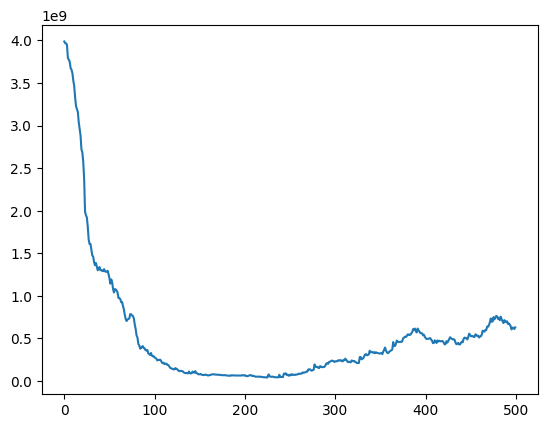

In [70]:
plt.plot(ds.volume.sum(dim='rgi_id'))